In [36]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

Populating the interactive namespace from numpy and matplotlib


### Подгрузим данные.

Данные дополнены до сентября 2017 года, данные за август 2016 скорректированы. http://sophist.hse.ru/exes/tables/WAG_M.htm

In [3]:
data = pd.read_csv('WAG_C_M_2017.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### 1. Визуальный анализ ряда

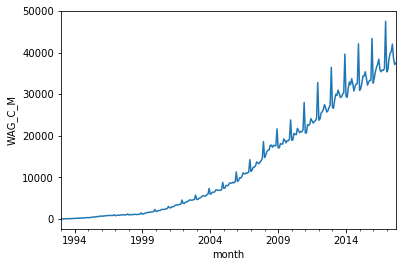

In [6]:
data.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Из графика можно сделать следующие выводы:

Есть годовая сезонность

Есть ярко выраженный тренд

Нестационарная дисперсия

То есть раяд нестационарен.

Посчитаем криетрий Дики-Фуллера для ряда:

In [7]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.990162


Гипотеза о нестационарности ряда не отвергается.

Выполним STL-декомпозицию ряда:

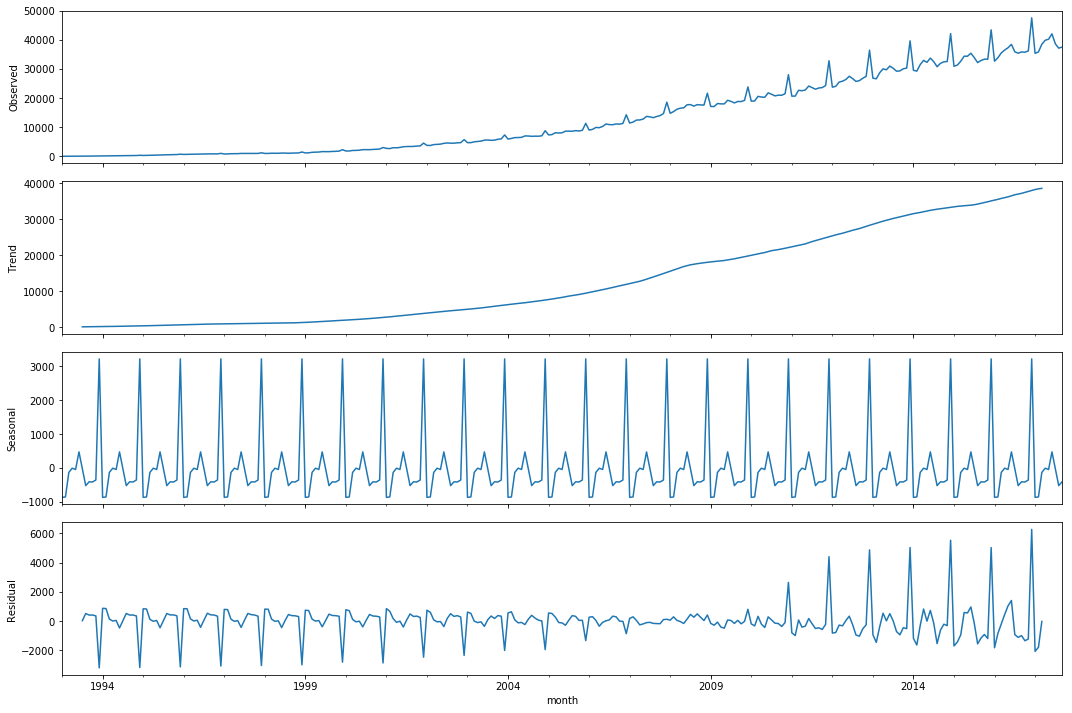

In [14]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(data.WAG_C_M).plot()

График тренда подтверждает наше утверждение о наличии тренда. Тренд растет нелиненйно.

График сезонности также подтверждает наличие сезонности.

На графике остатков мы видим сезонность.

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [19]:
data["WAG_C_M_box"], lmbda = stats.boxcox(data.WAG_C_M)

In [23]:
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.273037
Критерий Дики-Фуллера: p=0.646792


Видим, что критерий Дики-Фуллера уменьшился, но гипотезу о нестационарности уверенно не отвергает.

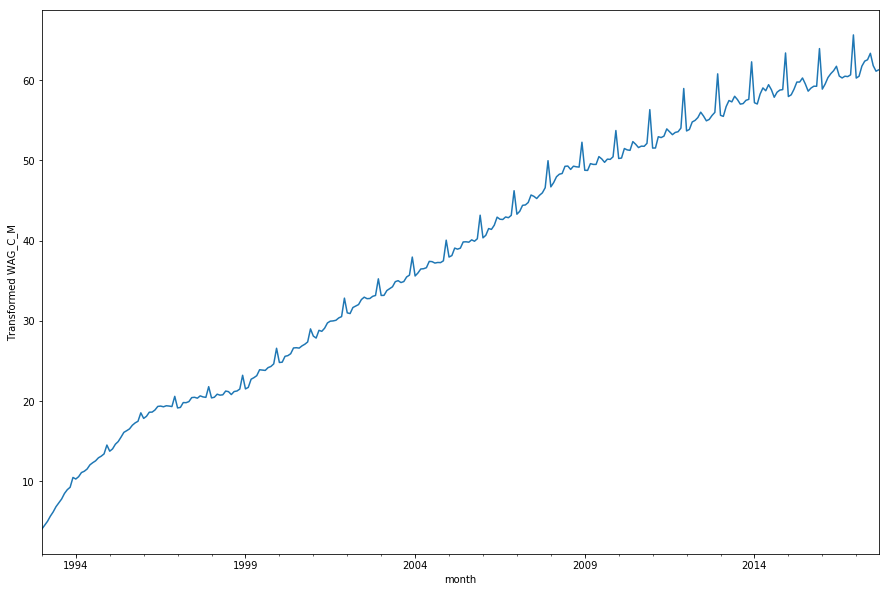

In [22]:
data.WAG_C_M_box.plot()
plt.ylabel('Transformed WAG_C_M')
pylab.show()

После преобразовения Бокса-Кокса дисперсия стабилизировалась, но не идеально, рост дисперсии все же заметен.

### 3. Выбор порядка дифференцирования

Из графика сезонности выше мы видим годовую сезонность. Продиффиренцируем со смещением 12.

In [27]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)

Выполним STL-декомпозицию ряда и посчитаем критерий Дики-Фуллера 

Критерий Дики-Фуллера: p=0.017973


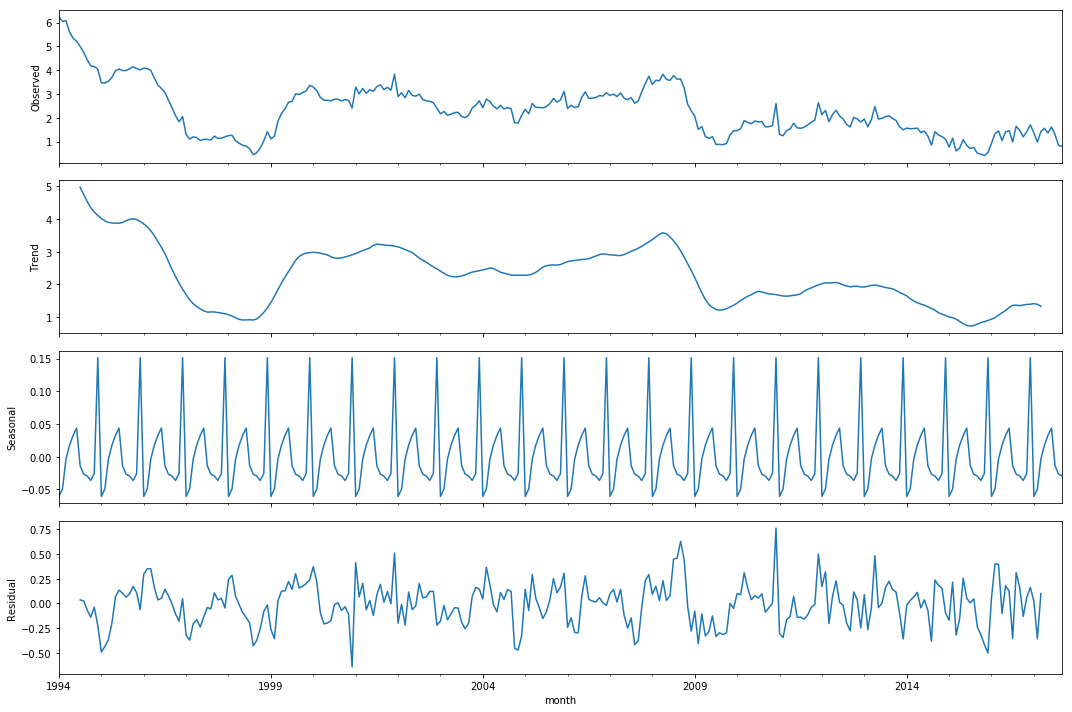

In [52]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

In [29]:
data['WAG_C_M_box_diff_2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)

Критерий Дики-Фуллера: p=0.000000


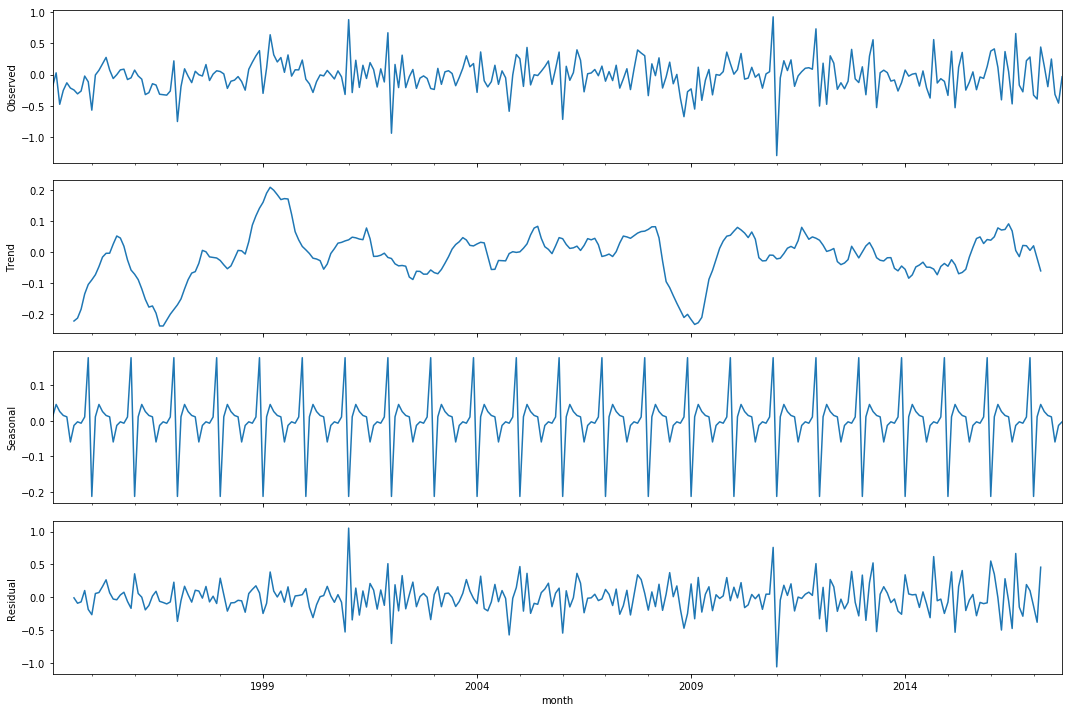

In [50]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff_2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff_2[13:])[1])

После двойного дифференцирования критерий Дики-Фуллера отвергает гипотезу нестационарности более уверенно, и тренд стал более похожим на шум. График остатков тоже выглядит как шум.

Будем считать ряд стационарным.

### 4.Выбор начальных приближений для p,q,P,Q

Построим график автокорреляции для определения начальных приближений Q и q

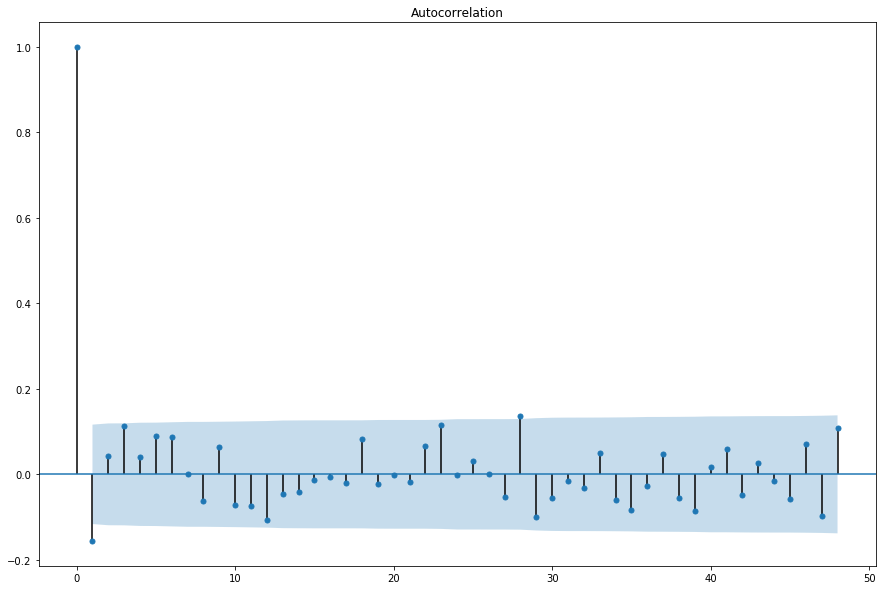

In [53]:
_ = sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff_2[13:].values.squeeze(), lags=48)

На графике нет ни одного значимого сезонного лага, отличающегося от нуля. Поэтому значений Q выбираем равное 0.

Максимальный значимый несезонный лаг, отличающийся от нуля и находящийся в пределах сезонного лага, равен 1. Значение q выбираем равное 1.

Построим график частичной автокорреляции для определения начальных приближений P и p

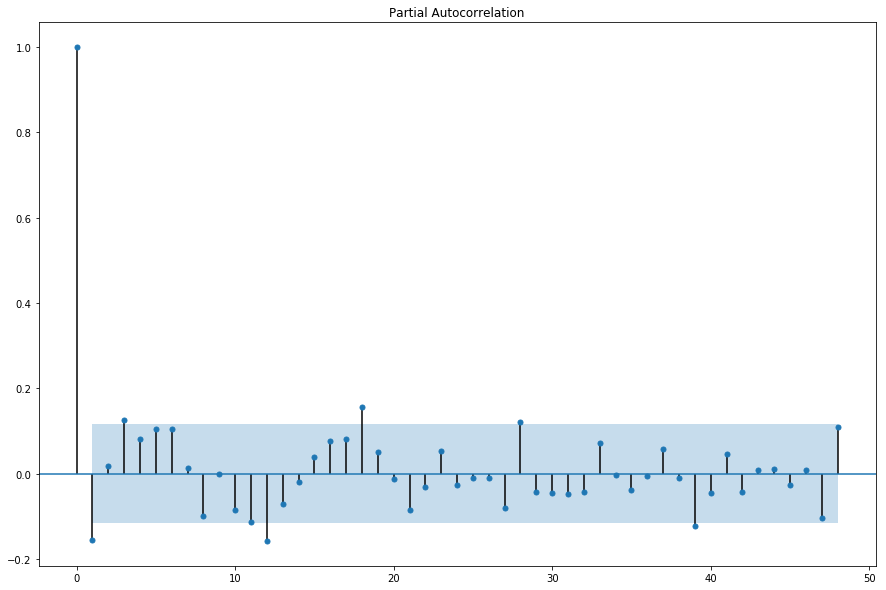

In [54]:
_ = sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff_2[13:].values.squeeze(), lags=48)

Самый большой значимый сезонный лаг на графике равен 12. Берем значение P равное 1.

Максимальный значимый несезонный лаг, отличающийся от нуля и находящийся в пределах сезонного лага, равен 3. Значение p выбираем равное 3.

Итого выбрали следующие начальные приближения: Q = 0, q = 1, P = 1, p = 3.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Подготовим параметры для перебора на соновании начальных приближений

In [35]:
ps = range(0, 4)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [37]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

Получилось 16 вариантов для перебора.

Построим все 16 моделей и отсортируем их по возрастанию значения критерия Акаике:

In [39]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
CPU times: user 4.88 s, sys: 126 ms, total: 5 s
Wall time: 3.76 s


In [40]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
12  (3, 1, 1, 0)  50.424607
10  (3, 0, 1, 0)  55.357002
11  (3, 1, 0, 0)  55.685596
4   (1, 0, 1, 0)  56.667494
2   (0, 1, 1, 0)  57.307551


Наилучшая модель имеет параметры: p = 3, q = 1, P = 1, Q = 0. Параметры соответсвуют начальным приближениям.

Посмотрим на лучшую модель:

In [41]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  297
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -19.212
Date:                            Sun, 05 Nov 2017   AIC                             50.425
Time:                                    11:04:04   BIC                             72.587
Sample:                                01-01-1993   HQIC                            59.297
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4574      0.198      2.305      0.021       0.068       0.846
ar.L2          0.1402      0.073   

Мы видим что, достигаемый уровень заничимости критерия Льюнга-Бокса = 0.28, то есть по все видимости остатки модели неавтокоррелированы.

### 6. Анализ остатков построенной модели

Выполним визуализацию остатков модели.

Критерий Стьюдента: p=0.274658
Критерий Дики-Фуллера: p=0.000000


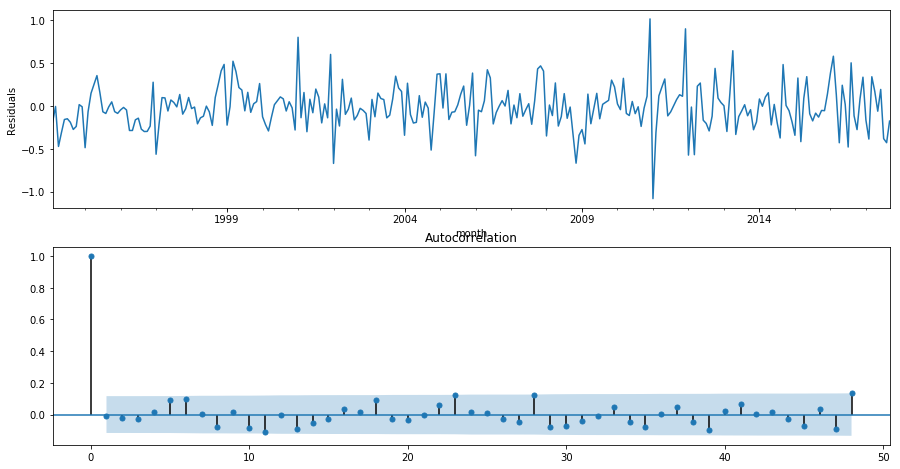

In [59]:
plt.figure(figsize(15,8))

plt.subplot(211)
_ = best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента = 0.27) стационарны (подтверждается критерием Дики-Фуллера = 0.00 и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим насколько хорошо модель описывает данные

In [60]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y + 1) / lmbda))

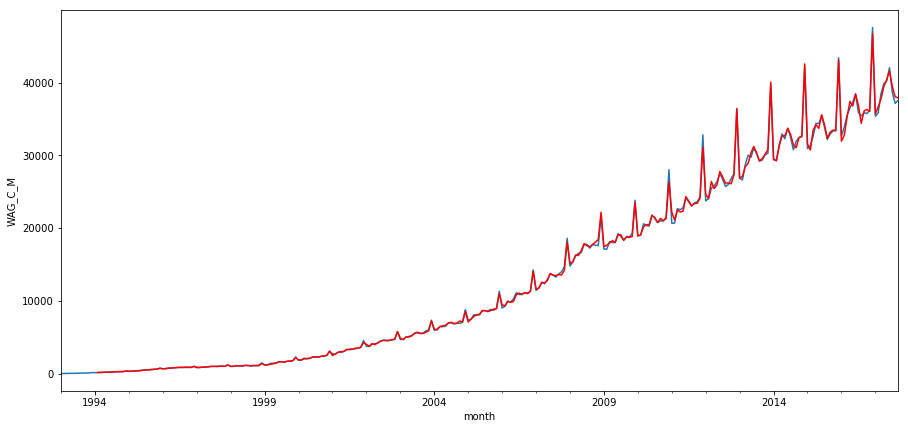

In [62]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

Судя по графику модель довольно точно описывает данные

### 7. Прогнозирование с помощью финальной модели.

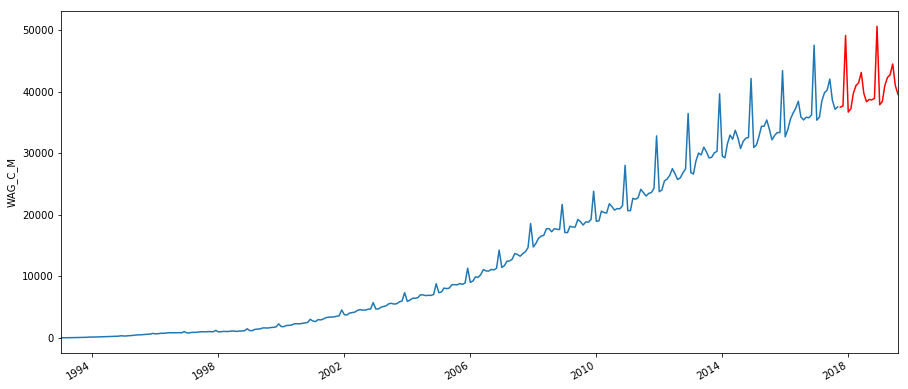

In [67]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2017-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=297, end=322), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

На графике красная линия показывает прогнозные значения зарплат в России на 2 года вперед помесячно начиная с октября 2017 года.

Прогноз выглядит правдоподобно (хотя на практике я бы не был так уверен :-)). Тренд сохраняется, сезонность тоже повторяет закономерности исторических данных.